# Graph-Based Recommenders with NetworkX

This 45 minute lesson walks through a minimal graph-based recommender workflow using NetworkX and pandas.

**Agenda**

- 0-5 min - Why graphs for recommender systems
- 5-10 min - Problem framing
- 10-22 min - Live build in NetworkX
- 22-34 min - Two recommenders
- 34-41 min - Fast evaluation

## 0-5 min - Why graphs for recommender systems

- Graphs model entities as nodes and relationships as edges, matching the user-to-item interactions we collect.
- Recommender data is naturally bipartite: one partition for users and one for items.
- Recommendations become link prediction or two-hop paths across that bipartite structure.
- Graphs give multi-relational context, trail transparency, and help with cold-start items that sit near popular neighbors.

## 5-10 min - Problem framing

- **Input:** time-stamped user-item interactions.
- **Output:** a ranked list of new items per user.
- Graph view: recommend items that sit close to a user via similar users or random walks.
- We will compare two simple methods: user-user Jaccard similarity and Personalized PageRank (PPR).

In [1]:
import polars as pl
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt

DATA_PATH = Path("interactions.csv")


Load the interaction log. Each row tells us which user touched which item and when.

In [2]:
interactions_df = pl.read_csv(DATA_PATH, try_parse_dates=True).sort("timestamp")
interactions_df.head()


user,item,timestamp
str,str,datetime[μs]
"""u13""","""i039""",2024-01-01 09:18:00
"""u12""","""i094""",2024-01-02 16:59:00
"""u23""","""i067""",2024-01-02 21:55:00
"""u24""","""i071""",2024-01-03 09:46:00
"""u09""","""i037""",2024-01-04 10:49:00


In [3]:
summary = {
    "users": interactions_df["user"].n_unique(),
    "items": interactions_df["item"].n_unique(),
    "interactions": interactions_df.height,
}
summary


{'users': 30, 'items': 99, 'interactions': 374}

## 10-22 min - Live build in NetworkX

We now turn the table into a bipartite graph where users and items live in separate partitions.

In [4]:
def build_bipartite_graph(df: pl.DataFrame) -> nx.Graph:
    """Return a bipartite graph with `bipartite` metadata on nodes."""
    B = nx.Graph()
    users = df["user"].unique().to_list()
    items = df["item"].unique().to_list()
    B.add_nodes_from(users, bipartite="users")
    B.add_nodes_from(items, bipartite="items")
    for row in df.iter_rows(named=True):
        B.add_edge(row["user"], row["item"], timestamp=row["timestamp"])
    return B


In [5]:
B_full = build_bipartite_graph(interactions_df)
print(f"Nodes: {B_full.number_of_nodes()} | Edges: {B_full.number_of_edges()}")
user_nodes = [n for n, data in B_full.nodes(data=True) if data["bipartite"] == "users"]
item_nodes = [n for n, data in B_full.nodes(data=True) if data["bipartite"] == "items"]
print(f"User nodes: {len(user_nodes)} | Item nodes: {len(item_nodes)}")

Nodes: 129 | Edges: 374
User nodes: 30 | Item nodes: 99


Confirm the metadata that tells us which partition each node belongs to.

In [6]:
for node in user_nodes[:5]:
    print(node, B_full.nodes[node])

u07 {'bipartite': 'users'}
u11 {'bipartite': 'users'}
u28 {'bipartite': 'users'}
u13 {'bipartite': 'users'}
u15 {'bipartite': 'users'}


A quick ego-graph paints how two-hop paths capture recommendation reach.

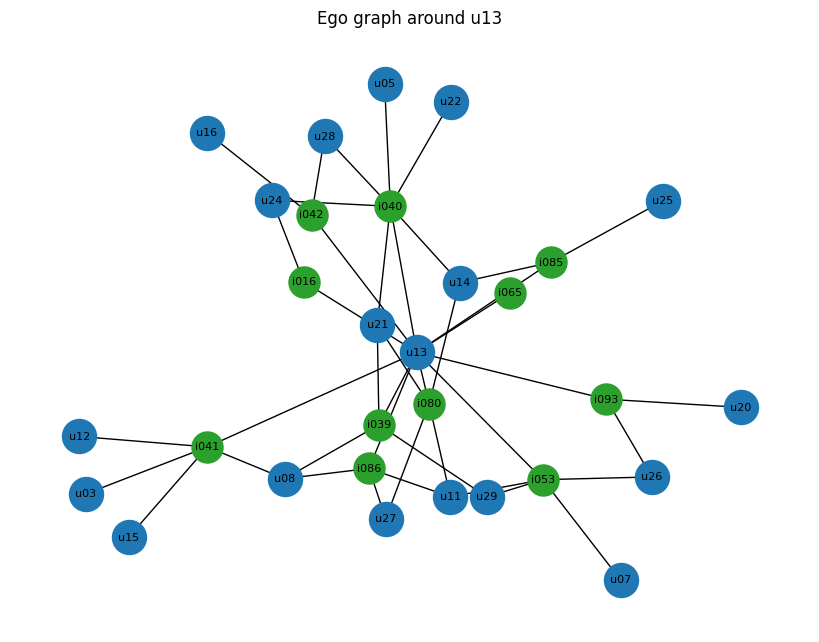

In [7]:
def plot_ego(B: nx.Graph, user: str, max_neighbors: int = 12) -> None:
    """Plot a spring layout of the ego network around the user."""
    if user not in B:
        raise ValueError(f"User {user} not present in the graph")
    items = list(B.neighbors(user))[:max_neighbors]
    nodes = {user, *items}
    for item in items:
        nodes.update(list(B.neighbors(item))[:6])
    ego = B.subgraph(nodes).copy()
    pos = nx.spring_layout(ego, seed=7)
    plt.figure(figsize=(8, 6))
    nx.draw(ego, pos, with_labels=True, node_size=400, font_size=8)
    nx.draw_networkx_nodes(
        ego,
        pos,
        nodelist=[n for n in ego.nodes if ego.nodes[n]["bipartite"] == "users"],
        node_size=600,
        node_color="tab:blue",
    )
    nx.draw_networkx_nodes(
        ego,
        pos,
        nodelist=[n for n in ego.nodes if ego.nodes[n]["bipartite"] == "items"],
        node_size=500,
        node_color="tab:green",
    )
    plt.title(f"Ego graph around {user}")
    plt.show()


example_user = interactions_df["user"][0]
plot_ego(B_full, example_user)

## 22-34 min - Two recommenders

We start with a graph-native Jaccard scorer that relies on NetworkX's link-prediction helpers and then compare it with Personalized PageRank.

In [24]:
from collections import defaultdict


def recommend_jaccard_graph(
    B: nx.Graph,
    user: str,
) -> pl.DataFrame:
    """Use NetworkX's jaccard_coefficient to score user-item links."""
    if user not in B:
        return pl.DataFrame({"product": [], "score": []})
    ego: nx.Graph = nx.ego_graph(B, user, radius=2, center=False)

    neighbors = [
        n for n, data in ego.nodes(data=True) if data.get("bipartite") == "users"
    ]
    seen = set(B.neighbors(user))
    ebunch = list((user, neighbor) for neighbor in neighbors)
    jaccard = dict([((u, v), p) for u, v, p in nx.jaccard_coefficient(B, ebunch)])
    scored_items = defaultdict(float)

    for neighbor in neighbors:
        for item in B.neighbors(neighbor):
            if item not in seen:
                scored_items[item] += (jaccard).get((user, neighbor), 0)

    return pl.DataFrame(
        {"product": list(scored_items.keys()), "score": list(scored_items.values())}
    )


demo_user = interactions_df["user"][0]
cf_demo = recommend_jaccard_graph(B_full, demo_user)

print(f"Demo user: {demo_user}")
print("Jaccard suggestions:", cf_demo.sort("score", descending=True).head(5))


Demo user: u13
Jaccard suggestions: shape: (5, 2)
┌─────────┬──────────┐
│ product ┆ score    │
│ ---     ┆ ---      │
│ str     ┆ f64      │
╞═════════╪══════════╡
│ i031    ┆ 0.783358 │
│ i059    ┆ 0.448332 │
│ i095    ┆ 0.445279 │
│ i013    ┆ 0.386518 │
│ i004    ┆ 0.352341 │
└─────────┴──────────┘


In [25]:
def recommend_ppr(
    B: nx.Graph, user: str, *, alpha: float = 0.85, max_iter: int = 100
) -> pl.DataFrame:
    """Run Personalized PageRank and return product scores."""
    if user not in B:
        return pl.DataFrame({"product": [], "score": []})
    personalization = {user: 1.0}
    scores = nx.pagerank(
        B, alpha=alpha, personalization=personalization, max_iter=max_iter
    )
    seen = set(B.neighbors(user))

    scored_items = {
        node: score
        for node, score in scores.items()
        if B.nodes[node].get("bipartite") == "items" and node not in seen
    }

    return pl.DataFrame(
        {"product": list(scored_items.keys()), "score": list(scored_items.values())}
    )


demo_user = interactions_df["user"][0]
ppr_demo = recommend_ppr(B_full, demo_user)
print(f"Demo user: {demo_user}")
print("PPR suggestions:", ppr_demo.sort("score", descending=True).head(5))

Demo user: u13
PPR suggestions: shape: (5, 2)
┌─────────┬──────────┐
│ product ┆ score    │
│ ---     ┆ ---      │
│ str     ┆ f64      │
╞═════════╪══════════╡
│ i031    ┆ 0.009069 │
│ i059    ┆ 0.005683 │
│ i076    ┆ 0.00535  │
│ i095    ┆ 0.005149 │
│ i013    ┆ 0.005048 │
└─────────┴──────────┘


## 34-41 min - Fast evaluation

We hold out each user's latest interaction and compute Precision@K and Recall@K for both recommenders.

In [ ]:
def train_test_split_last_item_per_user(
    df: pl.DataFrame,
) -> tuple[pl.DataFrame, pl.DataFrame]:
    """Hold out the last timestamped interaction per user."""
    df_sorted = df.sort(["user", "timestamp"]).with_row_index("row_id")
    test = df_sorted.group_by("user", maintain_order=True).tail(1)
    train = df_sorted.filter(~pl.col("row_id").is_in(test["row_id"]))
    return train.drop("row_id"), test.drop("row_id")



def precision_recall_at_k(
    recs: list[str], truth: list[str], k: int
) -> tuple[float, float]:
    """Return Precision@k and Recall@k for a recommendation list."""
    recs_k = recs[:k]
    hits = len(set(recs_k) & set(truth))
    precision = hits / max(1, len(recs_k))
    recall = hits / max(1, len(truth))
    return precision, recall



def to_user_items(df: pl.DataFrame) -> dict[str, set[str]]:
    """Collect the set of items interacted with by each user."""
    user_items: dict[str, set[str]] = defaultdict(set)
    for row in df.iter_rows(named=True):
        user_items[row["user"]].add(row["item"])
    return user_items



def evaluate_jaccard_graph(
    train_df: pl.DataFrame, test_df: pl.DataFrame, *, topn: int
) -> tuple[float, float, int]:
    train_graph = build_bipartite_graph(train_df)
    test_user_items = to_user_items(test_df)
    metrics: list[tuple[float, float]] = []
    for user, truth_items in test_user_items.items():
        if user not in train_graph:
            continue
        scores_df = recommend_jaccard_graph(train_graph, user)
        if scores_df.height == 0:
            continue
        recs = (
            scores_df
            .sort("score", descending=True)
            .head(topn)
            .get_column("product")
            .to_list()
        )
        precision, recall = precision_recall_at_k(recs, list(truth_items), topn)
        metrics.append((precision, recall))
    if not metrics:
        return 0.0, 0.0, 0
    precision_avg = sum(p for p, _ in metrics) / len(metrics)
    recall_avg = sum(r for _, r in metrics) / len(metrics)
    return precision_avg, recall_avg, len(metrics)



def evaluate_ppr(
    train_df: pl.DataFrame, test_df: pl.DataFrame, *, topn: int
) -> tuple[float, float, int]:
    train_graph = build_bipartite_graph(train_df)
    test_user_items = to_user_items(test_df)
    metrics: list[tuple[float, float]] = []
    for user, truth_items in test_user_items.items():
        if user not in train_graph:
            continue
        scores_df = recommend_ppr(train_graph, user)
        if scores_df.height == 0:
            continue
        recs = (
            scores_df
            .sort("score", descending=True)
            .head(topn)
            .get_column("product")
            .to_list()
        )
        precision, recall = precision_recall_at_k(recs, list(truth_items), topn)
        metrics.append((precision, recall))
    if not metrics:
        return 0.0, 0.0, 0
    precision_avg = sum(p for p, _ in metrics) / len(metrics)
    recall_avg = sum(r for _, r in metrics) / len(metrics)
    return precision_avg, recall_avg, len(metrics)


In [12]:
train_df, test_df = train_test_split_last_item_per_user(interactions_df)
top_k = 10
cf_prec, cf_rec, cf_users = evaluate_jaccard_graph(train_df, test_df, topn=top_k)
ppr_prec, ppr_rec, ppr_users = evaluate_ppr(train_df, test_df, topn=top_k)
print(
    f"Graph Jaccard Precision@{top_k}: {cf_prec:.3f} | Recall@{top_k}: {cf_rec:.3f} over {cf_users} users"
)
print(
    f"PPR Precision@{top_k}: {ppr_prec:.3f} | Recall@{top_k}: {ppr_rec:.3f} over {ppr_users} users"
)

C:\Users\Arnau\AppData\Local\Temp\ipykernel_19140\1898079562.py:5: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_sorted = df.sort(["user", "timestamp"]).with_row_count("row_id")
C:\Users\Arnau\AppData\Local\Temp\ipykernel_19140\1898079562.py:7: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  train = df_sorted.filter(~pl.col("row_id").is_in(test["row_id"]))


Graph Jaccard Precision@10: 0.013 | Recall@10: 0.133 over 30 users
PPR Precision@10: 0.013 | Recall@10: 0.133 over 30 users


### Wrap-up

- Collaborative filtering shines when users share dense interaction overlap.
- Personalized PageRank spreads preference signals through the graph and can surface items even with sparse direct overlap.
- Swap in richer edge weights or side information to extend the lesson.